In [1]:
import pandas as pd
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
from sklearn.datasets import load_boston
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%pylab inline
from scipy.stats import normaltest,boxcox,probplot, norm, loggamma
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from fractions import Fraction

Populating the interactive namespace from numpy and matplotlib


In [2]:
print (load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

# A QUICK REGRESSION TUTORIAL FOR BENNINERS
This is not a full data science tutorial. full exploration from the data analysis stand point will not be carried out in this notebook. This is quick tutorial on Regressions that focus more on Linear Regressions.How to evaluate them and improve them.

**SOME OTHER THINGS YOU CAN DO LEARNING FROM THIS TUTORIAL**<br>
Embedding steps in functions for good practice for real case scenario. ESPECIALLY TO STOP REPETION<br>
wrapping every step into a pipeline; This helps for a myriads of problems including quick debugging and flexibility...<br>
Using more ensemble of methods; algorithms such as XGBoost, LightBoost and Catboost are quite fast and efficient

In [3]:
boston_houses=load_boston()
boston=pd.DataFrame(data=boston_houses.data, columns=boston_houses.feature_names)
boston['MEDV']=boston_houses.target
boston.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
boston.shape

(506, 14)

In [5]:
boston.shape # good. 

(506, 14)

# QUICK EXPLORATION


Full exploration performed on perform is usually starts with having a great overview of the dataset features (by calling the .info( ) method on the dataset) then having a description of the dataset you are about the work on. However,the steps can be skipped by the using the Pandas_Profiling module that provides a much deeper description of dasets

In [6]:
ProfileReport(boston)

/Users/JB/anaconda3/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,14
Number of observations,506
Total Missing (%),0.0%
Total size in memory,55.5 KiB
Average record size in memory,112.3 B
Numeric,12
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


In [7]:
# tax is too correlated to RAD. I will remove it straight away
boston.drop('TAX',1, inplace=True)

In [8]:
boston.shape

(506, 13)

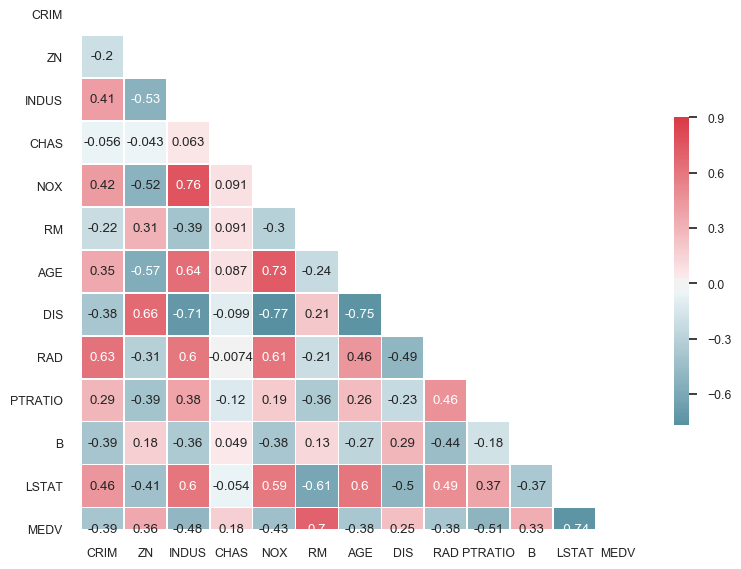

In [9]:
sns.set(font_scale=0.8) 
mask = np.zeros_like(boston.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set_style('white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(9,8))
sns.heatmap(boston.corr(), mask=mask, cmap=cmap, vmax=.9, center=0,square=True, linewidths=.5, 
            cbar_kws={"shrink": .5}, annot=True)

All the plots below show us that most of the variables in the dataset contain a lot of outliers. 
In this tutorial. We will just pretend that we do not have these outliers as this is not the objective of this video.

In [10]:
plt.style.use('ggplot')

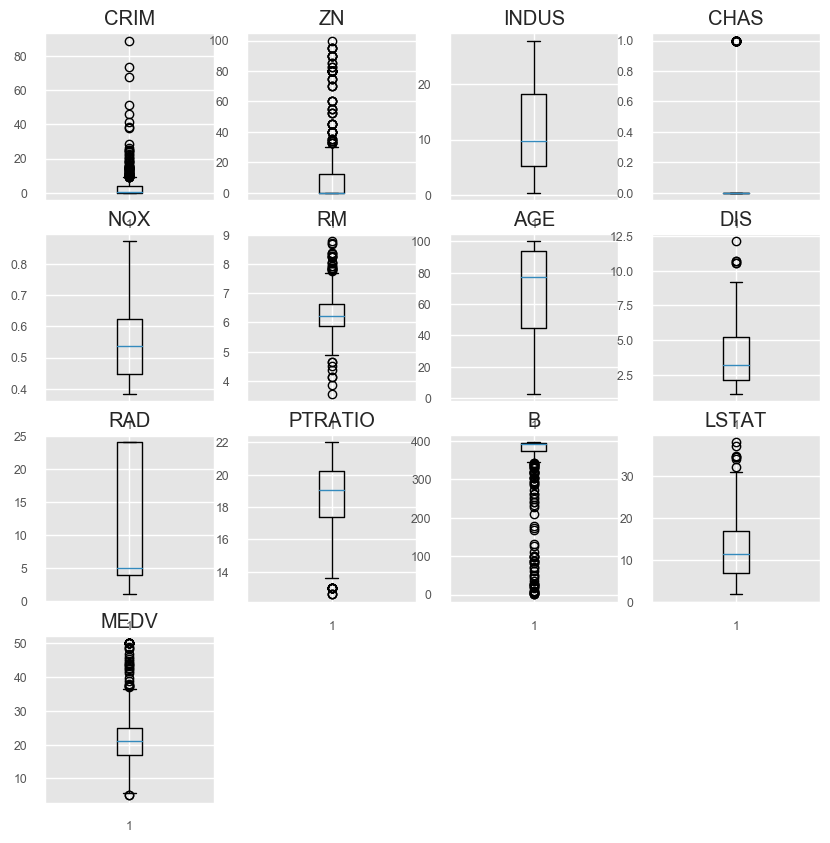

In [11]:
plt.figure(figsize=(10,10))

for i in range(len(boston.columns)):
    plt.subplot(4,4,(i+1))
    plt.boxplot(boston.iloc[:,i])
    plt.title(boston.columns[i])
    

**PLOTS ANALYSIS**<br>
There are quite a few of outliers in this dataset.What to do with the outliers really depends on the nature of your tasks.
However, in this task will ignore the outliers as this could be a study on his own. This is not the goal today :)

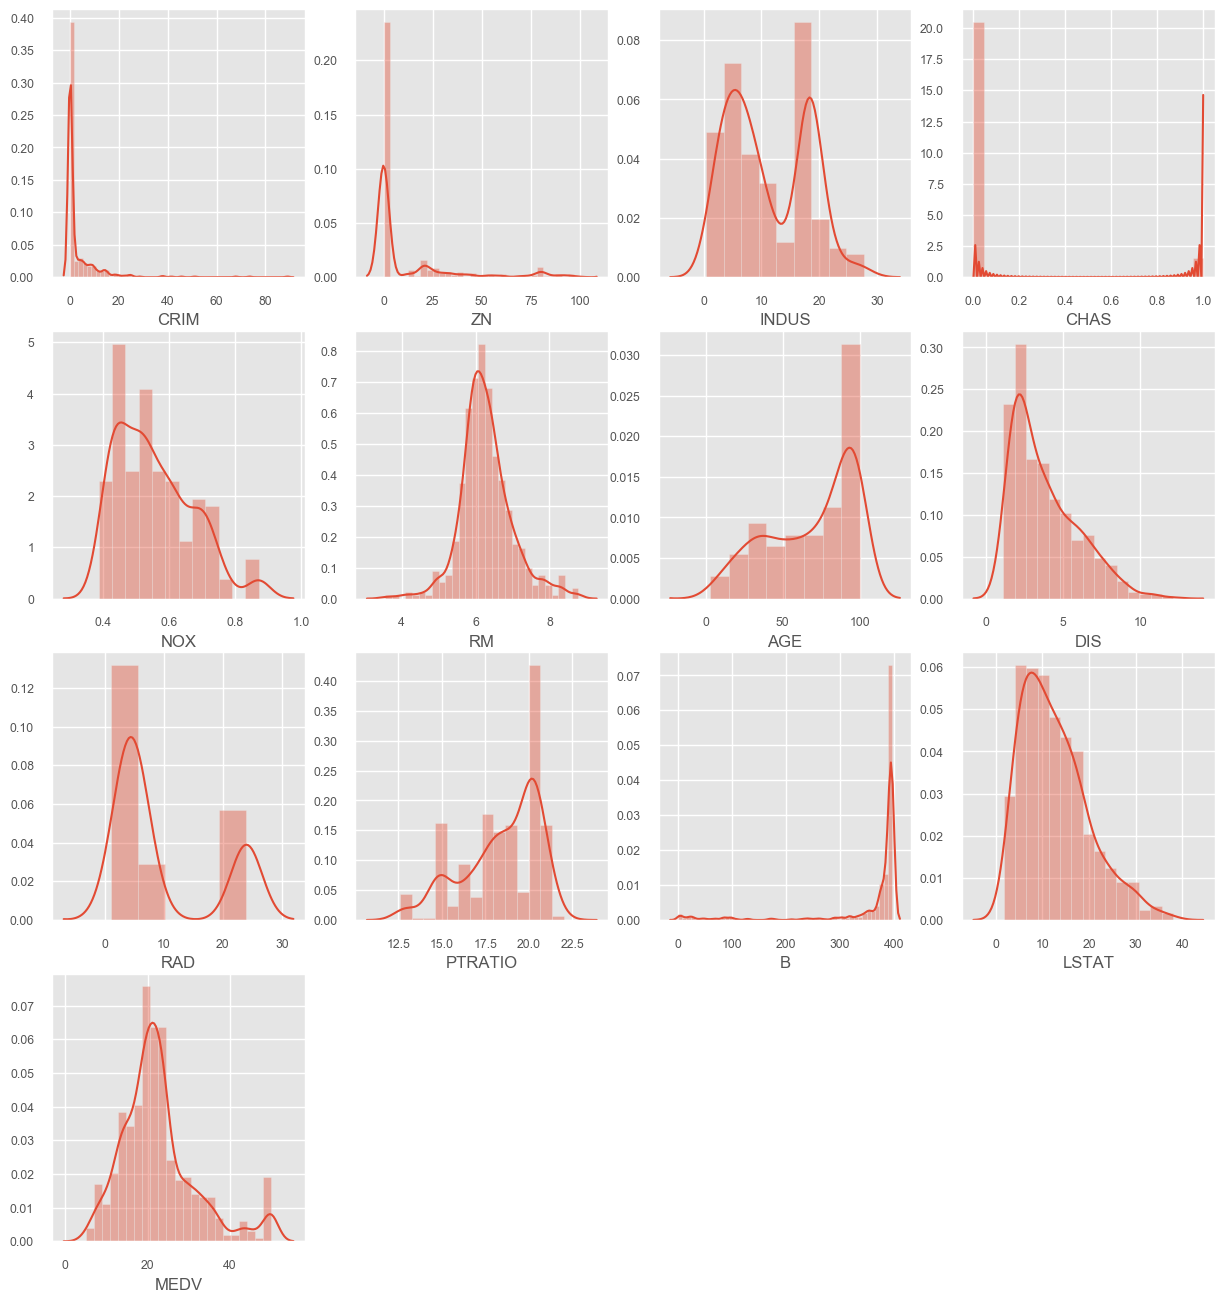

In [12]:
plt.figure(figsize=(15,16))
for i, col in enumerate(boston.columns):
        plt.subplot(4,4,i+1)
        sns.distplot(boston[col])

**PLOTS ANALYSIS**<br>
The plots above show us clearly that most of variables of our dataframe are not normally distributed. This is an important thing to check when visualising your data. Especially for the target variable as we gonna see later. if you still cannot see how this could help, please have a look at the assumptions of <b>Linear Regression</b>

# CHECKING LINEARITY WITH SCATTERPLOT

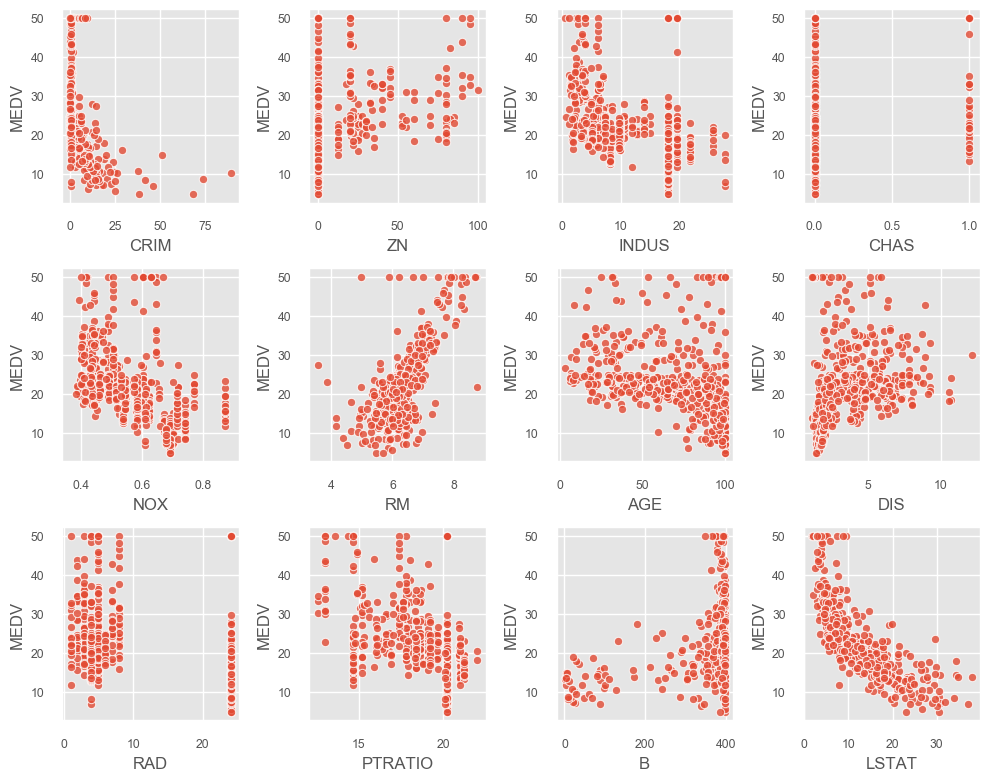

In [13]:
plt.figure(figsize=(10,10))
for i in range(len(boston.columns)-1):
    plt.subplot(4,4,(i+1))
    sns.scatterplot(boston.iloc[:,i],boston['MEDV'],alpha=0.8)
    plt.tight_layout()

**PLOTS ANALYSIS**<br>
Not too many of the independent variables have a considerable linear relationship with the target variable **MEDV**. The Linear regression could be choice to explain the house is price. However, these plots show us that it may not be best model to predict price  with a small margin of error.A non-Linear model would be more appropriate for it. I would be surprise to have a model that explain more than 80% of the variability, especially considering the size of the dataset (**506 observations**) but let's try.

def positivecol(data):
    """This function only drops columns contains zeroes or any values below it"""
    data=data.copy()
    for col in data.columns:
        if (data[col]<=0).any():
            data.drop(col,1, inplace=True)
    return data

In [14]:
X,y=boston.drop(columns='MEDV'),boston['MEDV']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [16]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

train_pred= lin_model.predict(X_train)
pred= lin_model.predict(X_test)

print ('Training R-squared:{}'.format(r2_score(y_train,train_pred)))
print ('Rmse:{}'.format(np.sqrt(mean_squared_error(y_train,train_pred))))
print ('')

print ('Testing R-squared:', r2_score(y_test, pred))
print ('Rmse:',format(np.sqrt(mean_squared_error(y_test,pred))))

Training R-squared:0.7368012133876127
Rmse:4.8165849735618975

Testing R-squared: 0.7141216361578363
Rmse: 4.651327568720472


# VISUAL CHECKING

In [17]:
sns.set_style('whitegrid')

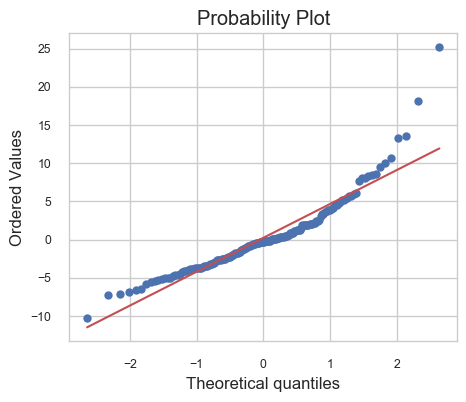

In [18]:
errors=y_test-(pred)

plt.figure(figsize=(5,4))
probplot(errors, plot=plt);

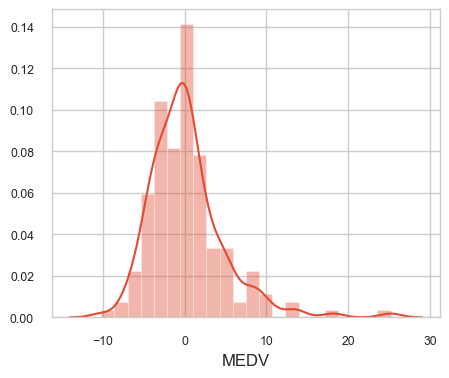

In [19]:
plt.figure(figsize=(5,4))
sns.distplot(errors)

**ANLYSIS**<br>
Great! there is no much difference my taining and my testing which tell us that I am not overfitting. Let's do a linear reg with scipy and compare the results. The scipy summary also gives so more details. I use it as a comaprative  tool as I cannot overfit using scipy.It's like using **Excel** to do a regression

In [20]:
X_new=sm.tools.tools.add_constant(X_train)
estimator= sm.OLS(y_train, X_new)
estimator.fit()

/Users/JB/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [21]:
print(estimator.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     76.05
Date:                Tue, 31 Dec 2019   Prob (F-statistic):           7.40e-87
Time:                        17:53:43   Log-Likelihood:                -1014.0
No. Observations:                 339   AIC:                             2054.
Df Residuals:                     326   BIC:                             2104.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.1070      6.246      5.141      0.0

**ANLYSIS**<br>
The results obtained with spciy are the same with the ones I have from sklearn on the trainning dataset. However, the summary results also tells that the p-value of few variables are not signficant (AGE,INDUS). Those variables dont have an impact on the target. they should be removed with at least a **backwards elimination**.<br> Remember that removing the variable would decrrease your R-squared but utimately improve your **Adjusted R-S**.

# LASSO, RIDGE , ELASTICNET with GRIDSEARCH

In [22]:
classifiers=[Lasso(max_iter=700,random_state=42),
             Ridge(max_iter=700,random_state=42), 
             ElasticNet(max_iter=700,random_state=42)]
rsqd=[]
rmses=[]
for clf in range(len(classifiers)):
    # First declare the variable parameters
    if clf==0:
        parameters={'alpha':[0.005,0.007,0.05,0.01,0.1,0.8]}

    elif clf==1:
         parameters = {'alpha':[0.1,1,5,10]}

    else:
        parameters ={'alpha':[0.05,0.5,0.01,0.1,1,5]}

    # Use clf as index to get the classifier
    current_clf = classifiers[clf]
    grid=GridSearchCV(current_clf, parameters,cv=5)

    # This is the correct classifier name, previously it returned int
    name = current_clf.__class__.__name__
    
    print("="*35)
    print(name)

    # Moved the below code inside the for loop
    grid.fit(X_train,y_train)
    pred=grid.predict(X_test)

    Rs = r2_score(y_test, pred)
    rmse=np.sqrt(mean_squared_error(y_test,pred))
    rsqd.append(Rs)
    rmses.append(rmse)

    print('The R-squared is {:.4}'.format(Rs))
    print('The root mean squared is {:.4}'.format(rmse))


/Users/JB/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Lasso
The R-squared is 0.7133
The root mean squared is 4.658
Ridge
The R-squared is 0.7133
The root mean squared is 4.658
ElasticNet
The R-squared is 0.7037
The root mean squared is 4.736


/Users/JB/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/JB/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**BASELINES(HOW GOOD ARE THE MODELS).**<br>
Establishing baselines are good way of the checking how your model is performing. In this exercise. I will use 2 baselines models.<br> <br>
1- Random Regressor which conists in building a similar to the outcome vector but filled with random values, and evaluate the predictions of that vector.<br>
2- Dummy Regressor from sklearn. Which is a regressor that makes predictions with simple rules.It is mainly used for comparison purposes and cannot be apply to real world problems

**Random Regressor**

In [23]:
#building the random regressor 
y_pred_rand=np.random.randint(np.min(y_train),np.max(y_train), y_test.shape)

# evaluation of the random regressor
print (np.sqrt(mean_squared_error(y_test,y_pred_rand)))

15.426416025028159


**Dummy Regressor**<br>
The dummy regressor from sklearn it always a very good way to evaluate a real regression model. In other terms, it is a regressor that makes predictions using simple rules and that should nt used for real world problems.

In [24]:
from sklearn.dummy import DummyRegressor
dum=DummyRegressor(strategy='mean')
dum.fit(X_train, y_train)

y_dum_pred=dum.predict(X_test)

print (np.sqrt(mean_squared_error(y_test,y_dum_pred)))
print (r2_score(y_test,y_dum_pred))

8.799980682431661
-0.023271489839964632


The resultats obtained by the baselines, clearly tell us that our regression are pretty good.

# KN-REGRESSION

**scaling data before nearest neighbor technique**

In [25]:
minmax_scale= MinMaxScaler()
train_X= minmax_scale.fit_transform(X_train)
test_X=minmax_scale.transform(X_test)

In [26]:
from sklearn.neighbors import KNeighborsRegressor

r_sqrd=[]
r_mcs=[]
for i in range(1,31):
    knn_reg=KNeighborsRegressor(n_neighbors=i)
    knn_reg.fit(train_X, y_train)
    knn_pred=knn_reg.predict(test_X)
    rmse= np.sqrt(mean_squared_error(y_test,knn_pred))
    score=r2_score(y_test,knn_pred)
    r_mcs.append(rmse)
    r_sqrd.append(score)

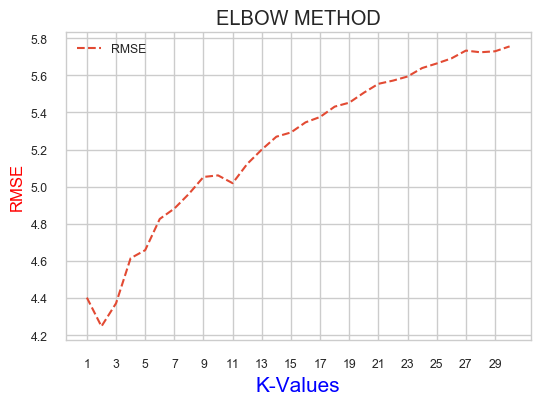

In [27]:
# Implementing the elbow method to determine the corrrect number of K
plt.figure(figsize=(6,4))
plt.title('ELBOW METHOD')
plt.plot(range(1,31), r_mcs, linestyle='--', label='RMSE')
plt.xlabel('K-Values',fontsize=15,color='blue')
plt.ylabel('RMSE',color='red')
plt.legend()
plt.xticks(range(1,30,2));

In [28]:
print('The Root-mean-squared for the knn is: %3f '% min(r_mcs))
print('The R-Squared for the knn is %3f '% max(r_sqrd))

The Root-mean-squared for the knn is: 4.247121 
The R-Squared for the knn is 0.761649 


Not a surprise here, the kn-reg as a non-linear method is doing much better than the linear models. However,  I was expecting a little more from **Elastic Net** . It is actually the poorest of all the models used

# IMPROVEMENT WITH TRANSFORMATION

In [29]:
# checking the normailty of the target variable
def normality_checker(var):
    stand_value=0.05
    """returns p-value and tells you if the varibale comes from a normal distribution"""
    _, p=normaltest(var)
    if p< stand_value:
        print('p-value =',p, ': too small.\nThe variable is not comming from a normal distribution')
    else:
        print('Your p-value is:',p, '\nYour data is normally distributed')


In [30]:
normality_checker((boston['MEDV']))

p-value = 1.7583188871696095e-20 : too small.
The variable is not comming from a normal distribution


**Let's change transform the data here, to make the y ditribution normal**

In [31]:
def transformer(var):
    trans=[np.log, np.exp,np.log10]
    stand_val=0.05
    
    for fn in trans:
        test= normaltest(fn(var))[1]
        if test>stand_val:
            break
            print('has normalised your variable with:', fn.__name__)
        else:
            print ( fn.__name__, '=== Failed')
            if fn== np.log10:
                print('Your last transformer has not normalised your data, try power_transformer')
            

In [32]:
transformer(boston['MEDV'])

log === Failed
exp === Failed
log10 === Failed
Your last transformer has not normalised your data, try power_transformer


In [33]:
def power_transformer(var,*args):
    """It takes variable  returns the 
    args being a decimal numberS from 1/2 to 1/5"""
    
    stand_val=0.05
    powr=[1/i for i in args]
    for i in powr:
        p_val=normaltest(power(var,i))[1]
        if p_val>stand_val:
            print('Your data has been normalised. Here is the power used:', Fraction(i))
            
        else:
            print('--'*12)
            

In [34]:
power_transformer(boston['MEDV'],1,2,3,4)

------------------------
------------------------
------------------------
Your data has been normalised. Here is the power used: 1/4


In [35]:
# checking the result of the transformer with the normality_checker
normality_checker(power(boston['MEDV'],1/4))

Your p-value is: 0.09626080866074743 
Your data is normally distributed


In [36]:
# let's restart everything again
X,y=boston.drop(columns='MEDV'),boston['MEDV']

In [37]:
# transforming y
y=power(y, 1/4)

In [38]:
# restarting the process
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [39]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

train_pred= lin_model.predict(X_train)
pred= lin_model.predict(X_test)

In [40]:
print ('Testing R-squared:', r2_score(y_test, pred))

Testing R-squared: 0.7570920929362925


This new model that is slightly better than the prvious one. But still not better than the kn-Reg. 

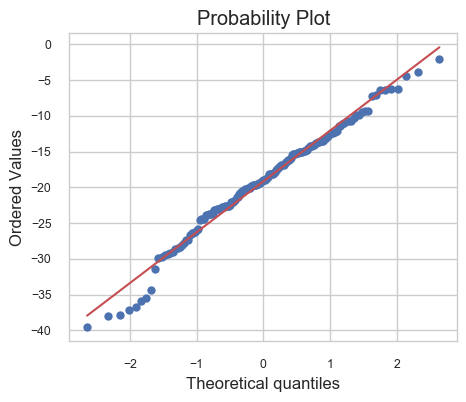

In [41]:
errors=y_test-pow(pred,4)

plt.figure(figsize=(5,4))
probplot(errors, plot=plt);

This is a slight improvement on the results we have seen before.<br> 
Please note that you could use other techniques if you are looking to get reduce your errors.I particularly, like using ensemble and Stacking techniques. Please noet that StackingReg and StackClass are now available on the latest version of sklearn. :)<br><br>
**This is just a quick Regression tuto, a lot things have to done in order to produce a reliable models. In this tuto, we have done much of exploration, no feature engineerring or feature selection. I leave that to you :); Some of those techniques will be demonstrated in other tutorials. See U :)**